# <center>基于时间差分的强化学习方法</center>

# 第 0 部分： CliffWalkingEnv场景
环境为

<img style="float: center;" src="1.jpg" width="40%" height="40%">

在任何阶段开始时，初始状态都是状态 `36`。状态 `47`是唯一的终止状态，悬崖对应的是状态 `37` 到 `46`。

智能体可以执行 4 个潜在动作：  
UP = 0  
RIGHT = 1  
DOWN = 2  
LEFT = 3  

因此，$\mathcal{S}^+=\{0, 1, \ldots, 47\}$ 以及 $\mathcal{A} =\{0, 1, 2, 3\}$。

In [1]:
import gym
env = gym.make('CliffWalking-v0')

最优状态值函数可视化结果如下。请立即花时间确保理解为何 这是最优状态值函数。

/home/huzhj/anaconda3/envs/kaggle/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


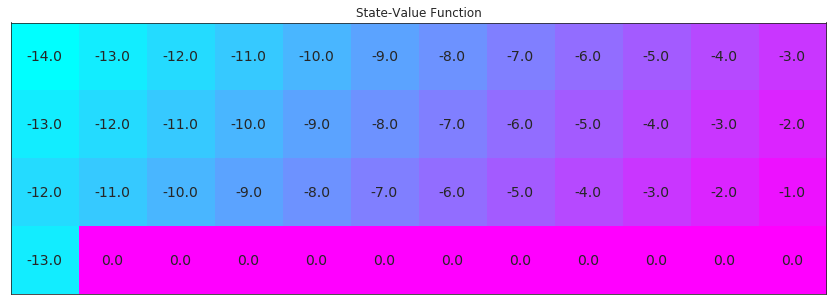

In [2]:
import numpy as np
from plot_utils import plot_values
 
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

# 第1部分：TD 预测 - 状态值
我们首先将研究智能体按以下方式移动的策略：
- 在状态 `0` 到 `10`（含）时向 `RIGHT` 移动， 
- 在状态 `11`、`23` 和 `35` 时向 `DOWN` 移动，
- 在状态 `12` 到 `22`（含）、状态 `24` 到 `34`（含）和状态 `36` 时向 `UP`移动。

下面指定并输出了该策略。注意，智能体没有选择动作的状态被标记为 `-1`。

In [3]:
policy = np.hstack([1*np.ones(11), 2, 0, np.zeros(10), 2, 0, np.zeros(10), 2, 0, -1*np.ones(11)])
print("\nPolicy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy.reshape(4,12))


Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.]
 [ 0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]


可视化与此策略相对应的状态值函数。

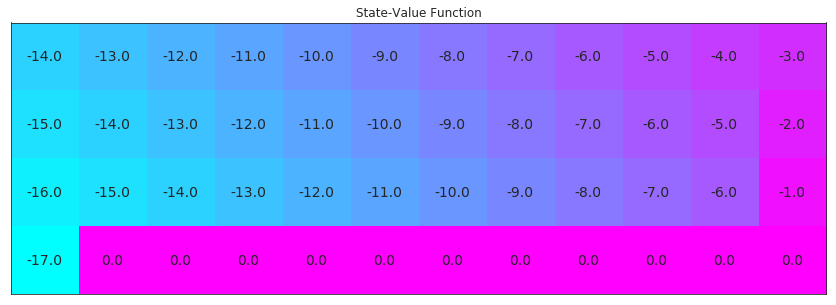

In [4]:
V_true = np.zeros((4,12))
for i in range(3):
    V_true[0:12][i] = -np.arange(3, 15)[::-1] - i
V_true[1][11] = -2
V_true[2][11] = -1
V_true[3][0] = -17
plot_values(V_true)

**接下来将通过 TD 预测算法尝试逼近上图的结果。**

TD 预测算法将包括 5 个参数：
- `env`：这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `policy`：这是一个一维 numpy 数组，其中 `policy.shape` 等于状态数量 (`env.nS`)。`policy[s]` 返回智能体在状态 `s` 时选择的动作。
- `alpha`：这是更新步骤的步长参数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：
- `V`：这是一个字典，其中 `V[s]` 是状态 `s` 的估算值。   

**TD更新方程为**  
$V(S_t)\leftarrow V(S_t)+\alpha(R_{t+1}+\gamma V(S_{t+1}-V(S_t))$  
注意这里的policy是前面已经给出的一个路线（策略）

In [5]:
from collections import defaultdict, deque
import sys
 
def td_prediction(env, num_episodes, policy, alpha, gamma=1.0):
    # initialize empty dictionaries of floats
    V = defaultdict(float)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        # begin an episode, observe S
        state = env.reset()
        while True:
            # choose action A
            action = policy[state]
            # take action A, observe R, S'
            next_state,reward,done,info = env.step(action)
            # perform updates
            V[state] = V[state] + alpha*(reward + (gamma*V[next_state]) - V[state])
            # S <- S'
            state = next_state
            # end episode if reached terminal state
            if done:
                break
 
    return V 

Episode 5000/5000

**<span style="color: green;">PASSED</span>**

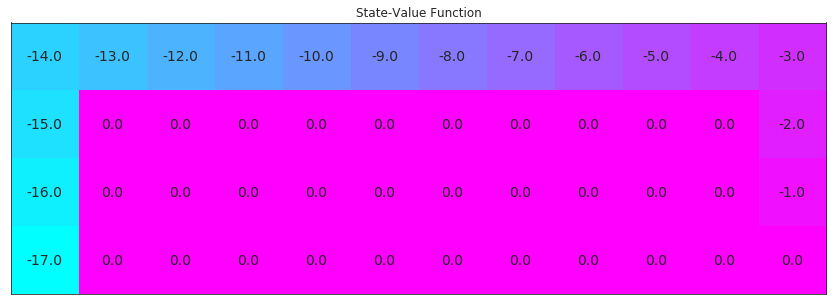

In [6]:
import check_test
 
# evaluate the policy and reshape the state-value function
V_pred = td_prediction(env, 5000, policy, .01)
 
# please do not change the code below this line
V_pred_plot = np.reshape([V_pred[key] if key in V_pred else 0 for key in np.arange(48)], (4,12)) 
check_test.run_check('td_prediction_check', V_pred_plot)
plot_values(V_pred_plot)

估算状态值函数与该策略对应的真状态值函数有多接近？ 

我们可能注意到了，有些状态值不是智能体估算的。因为根据该策略，智能体不会经历所有状态。在 TD 预测算法中，智能体只能估算所经历的状态对应的值。

# 第 2 部分：TD 控制 - Sarsa

在这部分将编写 Sarsa 控制算法的实现。

该算法将有四个参数：
- `env`：这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `alpha`：这是更新步骤的步长参数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：

- `Q`：这是一个字典（一维数组），其中 `Q[s][a]` 是状态 `s` 和动作 `a` 对应的估算动作值。


### Sarsa伪代码
<img style="float: center;" src="2.jpg" width="60%" height="60%">

### 行动策略：通过 $\epsilon$-greedy 策略来探索环境，产生action
$$\pi(a|s_t)=\begin{cases}
1-\epsilon+\dfrac{\epsilon}{|A(s)|},a=\arg\max_aQ(s,a)\\
\dfrac{\epsilon}{|A(s)|},a\neq\arg\max_aQ(s,a)
\end{cases}$$  

注意下面代码中Q_s，即公式中$Q(a|s_t)$维度与action空间维数相同；Qsa即伪代码中的$Q(S,A)$，是一个数

In [31]:
def epsilon_greedy_policy(env, Q_s, i_episode, eps=None):
    epsilon = 1.0 / i_episode
    if eps is not None:
        epsilon = eps
    Q_policy = np.ones(env.nA) * epsilon / env.nA
    Q_policy[np.argmax(Q_s)] = 1 - epsilon + (epsilon/env.nA)
    return Q_policy

def update_Q(Qsa, next_Qsa, reward, alpha, gamma):
    return Qsa + alpha * (reward + gamma * next_Qsa - Qsa)


In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
 
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        
        ## TODO: complete the function
        
        # initialize score
        score = 0
        # begin an episode, observe S
        state = env.reset()
        # get epsilon-greedy action probabilities
        policy_s = epsilon_greedy_policy(env,Q[state],i_episode)
        
        # pick action A
        action = np.random.choice(np.arange(env.nA),p=policy_s)
        
        # limit number of time steps per episode
        for t_step in np.arange(300):
            # take action A, observe R, S'
            next_state,reward,done,info = env.step(action)
            # add reward to score
            score += reward
            if not done:
                # get epsilon-greedy action probabilities
                policy_s = epsilon_greedy_policy(env,Q[next_state],i_episode)
                # pick next action A'
                next_action = np.random.choice(np.arange(env.nA),p=policy_s)
                # update TD estimate of Q
                Q[state][action] = update_Q(Q[state][action],Q[next_state][next_action],
                                         reward,alpha,gamma)
                
                # S <- S'
                state = next_state
                # A <- A'
                action = next_action
            if done:
                # update TD estimate of Q
                Q[state][action] = update_Q(Q[state][action],0,reward,alpha,gamma)
                # append score
                tmp_scores.append(score)
                break
        
        if(i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q

使用下个代码单元格可视化**_估算的_**最优策略和相应的状态值函数。  

如果代码单元格返回 **PASSED**，则表明你正确地实现了该函数！你可以随意更改提供给该函数的 `num_episodes` 和 `alpha` 参数。但是，如果你要确保单元测试的准确性，请勿更改 `gamma` 的默认值。

Episode 5000/5000

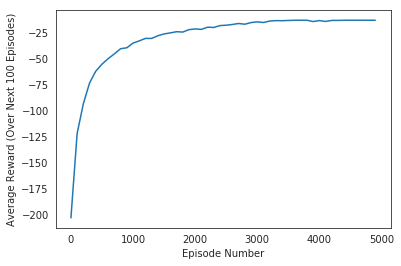

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  3  1  1  3  1  1  1  1  1  0  0]
 [ 2  1  1  1  2  0  1  1  1  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


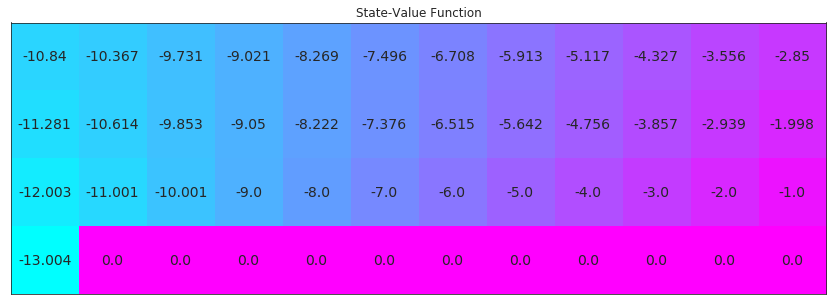

In [33]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)
# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)
# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### 第 3 部分：TD 控制 - Q 学习

算法将有四个参数：

- `env`：这是 OpenAI Gym 环境的实例。
- `num_episodes`：这是通过智能体-环境互动生成的阶段次数。
- `alpha`：这是更新步骤的步长参数。
- `gamma`：这是折扣率。它必须是在 0 到 1（含）之间的值，默认值为：`1`。

该算法会返回以下输出结果：

- `Q`：这是一个字典（一维数组），其中 `Q[s][a]` 是状态 `s` 和动作 `a` 对应的估算动作值。

<img style="float: center;" src="3.jpg" width="60%" height="60%">

In [34]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        plot_every = 100
        tmp_scores = deque(maxlen=plot_every)
        scores = deque(maxlen=num_episodes)
        
        score = 0
        state = env.reset()
        
        while True:
            policy_q = epsilon_greedy_policy(env, Q[state], i_episode)
            action = np.random.choice(np.arange(env.nA),p=policy_q)
            next_state,reward,done,info = env.step(action)
            Q[state][action] = Q[state][action] + alpha * (reward + gamma*np.max(Q[next_state]) - Q[state][action])
            score += reward
            
            state = next_state
            
            if done:
                tmp_scores.append(score)
                break
        
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
    return Q

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  2  1  1  1  0  1  1  3  1  3  0]
 [ 1  1  1  1  2  1  0  1  2  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


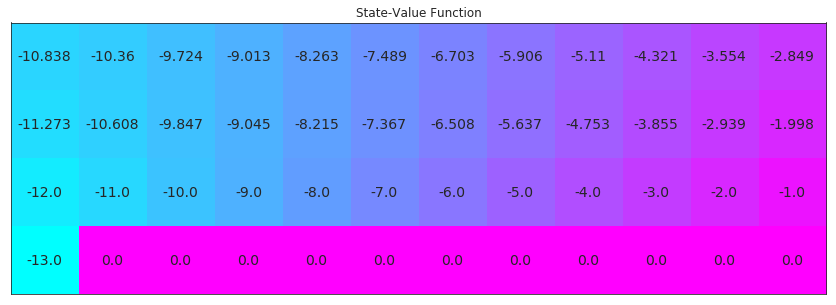

In [35]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])